# ML Feature enginerring - SelectKbest

In [1]:
%matplotlib inline
%run ../talibref.py
%run ensemble.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Get data

In [2]:
#df=pd.read_csv("data/IYZ.csv")
ticker = 'IYZ'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(IYZ) from 2000-05-26 to 2015-12-02
Usable data: Ticker(IYZ) from 2001-03-14 to 2015-12-02 
Returned data: Ticker(IYZ) from 2010-01-04 to 2015-12-02 
Save path: data/IYZ_from_2010-01-04_2015-12-02.csv


In [3]:
dftouse=df.copy()
print dftouse.shape

(1490, 78)


In [4]:
sent_df=pd.read_csv("data/tele_sent.csv")
dftouse['sentiment'] = sent_df['sentiment']

In [5]:
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,sentiment
0,2010-01-04,20.370001,20.549999,20.270000,20.549999,664200,20.680000,True,0.006326,18.719999,False,-0.089051,0,20.545079,19.9480,19.350920,1.004120,5.986360,False,True,False,0,19.245605,18.471530,18.441038,1,1,19.030765,18.366468,18.470379,1,1,19.822958,1,34.171492,33.666344,15.692957,True,True,1,96,1,122.917840,1,0.393756,0.403865,-0.010110,0,2.048084,1,79.657038,0,4.900454,0,68.259660,0,56.239960,0,-0.000000,0,694259.549529,1,49.166583,52.670801,0,81.338670,27.112890,0,0.164700,1,20.456666,22.773333,20.363333,22.866666,18.046666,25.183333,17.953333,0,0.65
1,2010-01-05,20.610001,20.760000,20.459999,20.680000,1214800,20.340000,False,-0.016441,18.900000,False,-0.086074,0,20.632786,20.0125,19.392214,1.038058,6.198986,False,True,False,0,19.301856,18.500781,18.463316,1,1,19.120883,18.404560,18.516717,1,1,19.881121,1,34.807420,36.435763,14.496814,True,True,1,100,1,149.707718,1,0.410108,0.405114,0.004994,1,2.058941,1,81.099707,0,4.444450,0,69.920669,0,60.808637,0,-6.666661,0,828264.024156,1,63.063063,50.743160,0,100.000000,60.446223,0,0.170615,1,20.633333,23.106666,20.506666,23.233333,18.033333,25.706666,17.906666,0,0.50
2,2010-01-06,20.719999,20.730000,20.270000,20.340000,804600,20.260000,False,-0.003933,18.600000,False,-0.085546,0,20.667400,20.0395,19.411600,0.739290,6.266626,False,False,False,0,19.342568,18.525142,18.481989,1,1,19.183869,18.435459,18.545405,1,1,19.969009,1,34.451424,32.362519,17.493670,True,True,1,96,1,85.708389,1,0.391124,0.402316,-0.011192,0,2.041574,1,76.927311,0,1.345291,0,60.938720,0,54.881580,0,-34.999971,0,629694.026402,1,77.477477,63.235708,0,10.627286,63.988652,1,0.175967,1,20.446667,22.583334,20.133333,22.896668,17.996666,25.033335,17.683332,0,0.50
3,2010-01-07,20.340000,20.379999,20.160000,20.260000,471900,20.110001,False,-0.007404,18.570000,False,-0.083416,0,20.677310,20.0705,19.463690,0.656144,6.046787,False,False,False,0,19.378545,18.548120,18.499681,1,1,19.249017,18.462442,18.574249,1,1,20.048108,1,33.614615,30.600584,19.263447,True,True,1,92,1,24.268894,1,0.365411,0.394935,-0.029524,0,1.902912,1,72.638398,0,-0.246179,0,59.017652,0,53.230087,0,-41.666632,0,477566.554469,1,54.954955,65.165165,0,0.000000,36.875762,1,0.180626,1,20.266666,22.223334,19.773333,22.716667,17.816665,24.673335,17.323332,1,0.50
4,2010-01-08,20.250000,20.250000,20.020000,20.110001,549100,20.150000,True,0.001989,18.400000,False,-0.085032,0,20.670872,20.0925,19.514128,0.515130,5.757097,False,False,False,0,19.407230,18.568807,18.515704,1,1,19.296817,18.485820,18.599729,1,1,20.760000,0,32.227258,28.760971,21.612208,True,True,1,88,1,-45.787970,1,0.329136,0.381775,-0.052639,0,1.685848,1,70.597898,0,-0.049702,0,55.485710,0,53.570511,0,-54.621765,0,333937.741315,1,29.279324,53.903919,0,0.000000,3.542429,1,0.184391,1,20.126667,21.943335,19.493334,22.576668,17.676666,24.393336,17.043333,0,0.50


### Feature Engineering

In [6]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [7]:
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

In [8]:
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

In [9]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               '^GSPC', #S&P500
               #'^dji',  #Dow Jones Industrials
               #'^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc','stoch_slowk']
INDICATORS_TO_ADD = ['cci_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^GSPC....
Available data: Ticker(^GSPC) from 1950-01-03 to 2015-12-02
Usable data: Ticker(^GSPC) from 1962-05-28 to 2015-12-02 
Returned data: Ticker(^GSPC) from 2010-01-04 to 2015-12-02 
Save path: data/^GSPC_from_2010-01-04_2015-12-02.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006-08-16 to 2015-12-02
Usable data: Ticker(OIL) from 2007-06-05 to 2015-12-02 
Returned data: Ticker(OIL) from 2010-01-04 to 2015-12-02 
Save path: data/OIL_from_2010-01-04_2015-12-02.csv


,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,sentiment,roc_^GSPC,stoch_slowk_^GSPC,cci_signal_^GSPC,roc_OIL,stoch_slowk_OIL,cci_signal_OIL
0,2010-01-04,20.370001,20.549999,20.270000,20.549999,664200,20.680000,True,0.006326,18.719999,False,-0.089051,0,20.545079,19.9480,19.350920,1.004120,5.986360,False,True,False,0,19.245605,18.471530,18.441038,1,1,19.030765,18.366468,18.470379,1,1,19.822958,1,34.171492,33.666344,15.692957,True,True,1,96,1,122.917840,1,0.393756,0.403865,-0.010110,0,2.048084,1,79.657038,0,4.900454,0,68.259660,0,56.239960,0,-0.000000,0,694259.549529,1,49.166583,52.670801,0,81.338670,27.112890,0,0.164700,1,20.456666,22.773333,20.363333,22.866666,18.046666,25.183333,17.953333,0,0.65,3.367458,56.569007,1,11.120401,91.158111,0
1,2010-01-05,20.610001,20.760000,20.459999,20.680000,1214800,20.340000,False,-0.016441,18.900000,False,-0.086074,0,20.632786,20.0125,19.392214,1.038058,6.198986,False,True,False,0,19.301856,18.500781,18.463316,1,1,19.120883,18.404560,18.516717,1,1,19.881121,1,34.807420,36.435763,14.496814,True,True,1,100,1,149.707718,1,0.410108,0.405114,0.004994,1,2.058941,1,81.099707,0,4.444450,0,69.920669,0,60.808637,0,-6.666661,0,828264.024156,1,63.063063,50.743160,0,100.000000,60.446223,0,0.170615,1,20.633333,23.106666,20.506666,23.233333,18.033333,25.706666,17.906666,0,0.50,3.088524,65.580311,1,10.696517,94.360616,0
2,2010-01-06,20.719999,20.730000,20.270000,20.340000,804600,20.260000,False,-0.003933,18.600000,False,-0.085546,0,20.667400,20.0395,19.411600,0.739290,6.266626,False,False,False,0,19.342568,18.525142,18.481989,1,1,19.183869,18.435459,18.545405,1,1,19.969009,1,34.451424,32.362519,17.493670,True,True,1,96,1,85.708389,1,0.391124,0.402316,-0.011192,0,2.041574,1,76.927311,0,1.345291,0,60.938720,0,54.881580,0,-34.999971,0,629694.026402,1,77.477477,63.235708,0,10.627286,63.988652,1,0.175967,1,20.446667,22.583334,20.133333,22.896668,17.996666,25.033335,17.683332,0,0.50,2.072615,95.490211,1,13.871370,96.383747,0
3,2010-01-07,20.340000,20.379999,20.160000,20.260000,471900,20.110001,False,-0.007404,18.570000,False,-0.083416,0,20.677310,20.0705,19.463690,0.656144,6.046787,False,False,False,0,19.378545,18.548120,18.499681,1,1,19.249017,18.462442,18.574249,1,1,20.048108,1,33.614615,30.600584,19.263447,True,True,1,92,1,24.268894,1,0.365411,0.394935,-0.029524,0,1.902912,1,72.638398,0,-0.246179,0,59.017652,0,53.230087,0,-41.666632,0,477566.554469,1,54.954955,65.165165,0,0.000000,36.875762,1,0.180626,1,20.266666,22.223334,19.773333,22.716667,17.816665,24.673335,17.323332,1,0.50,2.117129,96.100927,1,11.928517,90.221762,0
4,2010-01-08,20.250000,20.250000,20.020000,20.110001,549100,20.150000,True,0.001989,18.400000,False,-0.085032,0,20.670872,20.0925,19.514128,0.515130,5.757097,False,False,False,0,19.407230,18.568807,18.515704,1,1,19.296817,18.485820,18.599729,1,1,20.760000,0,32.227258,28.760971,21.612208,True,True,1,88,1,-45.787970,1,0.329136,0.381775,-0.052639,0,1.685848,1,70.597898,0,-0.049702,0,55.485710,0,53.570511,0,-54.621765,0,333937.741315,1,29.279324,53.903919,0,0.000000,3.542429,1,0.184391,1,20.126667,21.943335,19.493334,22.576668,17.676666,24.393336,17.043333,0,0.50,2.176533,95.794862,1,8.644949,83.315586,0


In [10]:
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values
mask.shape, mask.sum()

((1490,), 1258)

#### 1.2 Standardize the data

Use the mask to compute the training and test parts of the dataframe. Use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [11]:
#your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,sentiment,roc_^GSPC,stoch_slowk_^GSPC,cci_signal_^GSPC,roc_OIL,stoch_slowk_OIL,cci_signal_OIL
0,2010-01-04,-1.169181,-1.157299,-1.15216,-1.118360,0.639008,20.680000,True,0.006326,18.719999,False,-0.089051,0,-1.321332,-1.279148,-1.221656,1.341702,-0.221542,False,True,False,0,-1.460919,-1.606757,-1.590867,1,1,-1.591087,-1.687069,-1.676153,1,1,-1.257753,1,1.219553,1.264466,-1.068669,True,True,1,1.313898,1,1.004782,1,1.390227,1.549988,-0.096380,0,1.164215,1,1.561731,0,1.442156,0,1.356830,0,0.191720,0,1.334246,0,1.564001,1,-0.269844,-0.148049,0,0.698039,-0.732738,0,1.451422,1,-1.142985,-0.827349,-0.890331,-1.051099,-1.175919,-0.728905,-0.909411,0,0.65,1.022709,-0.171535,1,2.097356,1.481709,0
1,2010-01-05,-1.101747,-1.098349,-1.09877,-1.081848,2.142760,20.340000,False,-0.016441,18.900000,False,-0.086074,0,-1.296796,-1.260871,-1.209938,1.443046,-0.155418,False,True,False,0,-1.444752,-1.598041,-1.584059,1,1,-1.563987,-1.675790,-1.662338,1,1,-1.241792,1,1.295293,1.656456,-1.216766,True,True,1,1.378875,1,1.253799,1,1.457677,1.555591,0.078078,1,1.171118,1,1.645223,0,1.297461,0,1.505069,0,0.626544,0,1.120493,0,1.930265,1,0.257237,-0.227046,0,1.139066,0.256536,0,1.519308,1,-1.093350,-0.737175,-0.851602,-0.950513,-1.179561,-0.593715,-0.921427,0,0.50,0.922154,0.160817,1,2.019937,1.603270,0
2,2010-01-06,-1.070840,-1.106770,-1.15216,-1.177339,1.022456,20.260000,False,-0.003933,18.600000,False,-0.085546,0,-1.287113,-1.253220,-1.204436,0.550893,-0.134384,False,False,False,0,-1.433052,-1.590782,-1.578353,1,1,-1.545047,-1.666641,-1.653785,1,1,-1.217674,1,1.252893,1.079920,-0.845719,True,True,1,1.313898,1,0.658914,1,1.379371,1.543035,-0.108883,0,1.160075,1,1.403751,0,0.314070,0,0.703464,0,0.062437,0,0.212042,0,1.387529,1,0.803962,0.284918,0,-0.973098,0.361669,1,1.580734,1,-1.145794,-0.878748,-0.952477,-1.042869,-1.189577,-0.767654,-0.978934,0,0.50,0.555921,1.263944,1,2.599800,1.680065,0
3,2010-01-07,-1.177611,-1.205021,-1.18307,-1.199808,0.113814,20.110001,False,-0.007404,18.570000,False,-0.083416,0,-1.284341,-1.244436,-1.189654,0.302612,-0.202750,False,False,False,0,-1.422711,-1.583935,-1.572947,1,1,-1.525456,-1.658651,-1.645185,1,1,-1.195968,1,1.153228,0.830531,-0.626599,True,True,1,1.248921,1,0.087822,1,1.273312,1.509911,-0.320626,0,1.071905,1,1.155536,0,-0.190918,0,0.532015,0,-0.094744,0,-0.001712,0,0.971730,1,-0.050296,0.363990,0,-1.224255,-0.442993,1,1.634198,1,-1.196366,-0.976136,-1.049750,-1.092248,-1.238745,-0.860651,-1.071632,1,0.50,0.571968,1.286468,1,2.244953,1.446167,0
4,2010-01-08,-1.202899,-1.241514,-1.22241,-1.241936,0.324656,20.150000,True,0.001989,18.400000,False,-0.085032,0,-1.286142,-1.238202,-1.175341,-0.118472,-0.292838,False,False,False,0,-1.414467,-1.577770,-1.568050,1,1,-1.511082,-1.651729,-1.637589,1,1,-1.000611,0,0.987992,0.570148,-0.335794,True,True,1,1.183944,1,-0.563369,1,1.123685,1.450854,-0.587622,0,0.933880,1,1.037445,0,-0.128574,0,0.216803,0,-0.062344,0,-0.417092,0,0.579160,1,-1.024149,-0.097513,0,-1.224255,-1.432267,1,1.677407,1,-1.235698,-1.051881,-1.125406,-1.130653,-1.276986,-0.932983,-1.143730,0,0.50,0.593383,1.275180,1,1.645234,1.184022,0


We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [12]:
#lcols=list(dftouse.columns)
#lcols.remove(u'results')
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

77


### EDA for the data

We create a variable `ccols` which contains all variables not in our indicators list

In [13]:
ccols=[]
for c in lcols:
    if c not in INDICATORS and c not in IGNORE:
        ccols.append(c)
print len(ccols), len(INDICATORS)

49 28


In [14]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=2)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [15]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [16]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [17]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.465100671141
training set 0.467408585056 test set 0.452586206897


#####our data is not very asymmetric, but we might still want to balance the trainset

### Balancing train set to test set for training, 
### intended to be used with SVM only

In [18]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
print Xtrain_new.shape, ytrain_new.shape

reuse_split_balanced=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

588 670
(1176, 77) (1176,)


## Test all classifiersres using SelectKbest

In [19]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', True, [1])
    _,_,ROI_long,bal_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals,bal_over_time

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [21]:
%%time
max_number_featrues = 20
Results={}
scoring_func="accuracy"


print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Results["log_regression"] = evaluate(pipeLR)[0:5]

#############====================== Log Regression =====================#############
0.1
Number of features: 20
Features: ['bb_pct', 'sar_signal', 'plus_di', 'minus_di', 'adx_direction', 'cci', 'macd', 'macd_hist', 'macd_signal', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd', 'srsi_signal', 'roc_^GSPC', 'stoch_slowk_^GSPC']
train accuracy: 0.698728139905
test accuracy: 0.689655172414
ROI baseline: 0.00816
ROI long-only: 0.0813992825
ROI long-short: 0.1543975339
CPU times: user 11.2 s, sys: 1.14 s, total: 12.3 s
Wall time: 20.3 s


In [22]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Results["RBF_SVM"] = evaluate(pipesvm2)[0:5]

#############====================== RBF SVM ===========================#############
10000.0 1e-07
Number of features: 18
Features: ['bb_pct', 'sar_signal', 'plus_di', 'minus_di', 'adx_direction', 'cci', 'macd_hist', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd', 'srsi_signal', 'roc_^GSPC', 'stoch_slowk_^GSPC']
train accuracy: 0.699523052464
test accuracy: 0.737068965517
ROI baseline: 0.00816
ROI long-only: 0.1469217814
ROI long-short: 0.2977225315
CPU times: user 43.5 s, sys: 6.63 s, total: 50.1 s
Wall time: 2min 30s


In [23]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Results["Random_forest"] = evaluate(pipeRF)[0:5]

#############====================== Random Forest =====================#############
3 20 1
Number of features: 6
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'willr', 'stoch_slowk']
train accuracy: 0.706677265501
test accuracy: 0.681034482759
ROI baseline: 0.00816
ROI long-only: 0.1000943911
ROI long-short: 0.1923747692
CPU times: user 18.4 s, sys: 3.16 s, total: 21.6 s
Wall time: 43.9 s


In [24]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Results["Extra_Trees"] = evaluate(pipeET)[0:5]

#############====================== Extra Trees= =====================#############
ET__max_depth: 3
ET__n_estimators: 10
ET__max_features: 1
Number of features: 6
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'willr', 'stoch_slowk']
train accuracy: 0.682829888712
test accuracy: 0.711206896552
ROI baseline: 0.00816
ROI long-only: 0.1798078468
ROI long-short: 0.3693971566
CPU times: user 49.9 s, sys: 7.52 s, total: 57.4 s
Wall time: 1min 45s


In [25]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Results["Gaussian_NB"] = evaluate(pipeNB)[0:5]

#############====================== Gaussian NB ==========================#############
Number of features: 5
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'stoch_slowk']
train accuracy: 0.690779014308
test accuracy: 0.681034482759
ROI baseline: 0.00816
ROI long-only: 0.0900466797
ROI long-short: 0.1738838311
CPU times: user 2.54 s, sys: 464 ms, total: 3 s
Wall time: 5.37 s


In [26]:
#%%time
#print "#############====================== Gradient Boosting ====================#############"
#pipeGB = Pipeline([('selectk', selectk), ('GB', GradientBoostingClassifier())])
#pipeGB, _,_,_,_  = do_classify(pipeGB, {"selectk__k":range(1,max_number_featrues+1), 
#                                        "GB__n_estimators": [5,10,20,40],
#                                        "GB__learning_rate": [0.1,0.5,1.0],
#                                        "GB__random_state": [111]}, 
#                               dftouse,lcols, u'results',1, reuse_split=reuse_split)
#print pipeGB.get_params()['GB__n_estimators'], pipeGB.get_params()['GB__learning_rate']
#print_result(pipeGB)
#Long_ROI_result["Gradient_bossting"] = evaluate(pipeGB)[3]
#Test_set_accuracies["Gradient_bossting"] = evaluate(pipeGB)[1]

In [27]:
print "#############====================== ENSEMBLE ==========================#############"
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Results["Ensemble"] = r[0:5]
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

#############====================== ENSEMBLE ==========================#############
train accuracy: 0.697138314785
test accuracy: 0.715517241379
ROI baseline: 0.00816
ROI long-only: 0.151752135
ROI long-short: 0.3092007182


In [28]:
print "---Test accuracy results---"
for key, value in Results.iteritems():
    print key, value[1]

---Test accuracy results---
RBF_SVM 0.737068965517
Extra_Trees 0.711206896552
Gaussian_NB 0.681034482759
log_regression 0.689655172414
Random_forest 0.681034482759
Ensemble 0.715517241379


In [29]:
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
for key, value in Results.iteritems():
    print key, value[3]

ROI baseline: 0.00816
---Long ROI results---
RBF_SVM 0.1469217814
Extra_Trees 0.1798078468
Gaussian_NB 0.0900466797
log_regression 0.0813992825
Random_forest 0.1000943911
Ensemble 0.151752135


/Users/ela/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


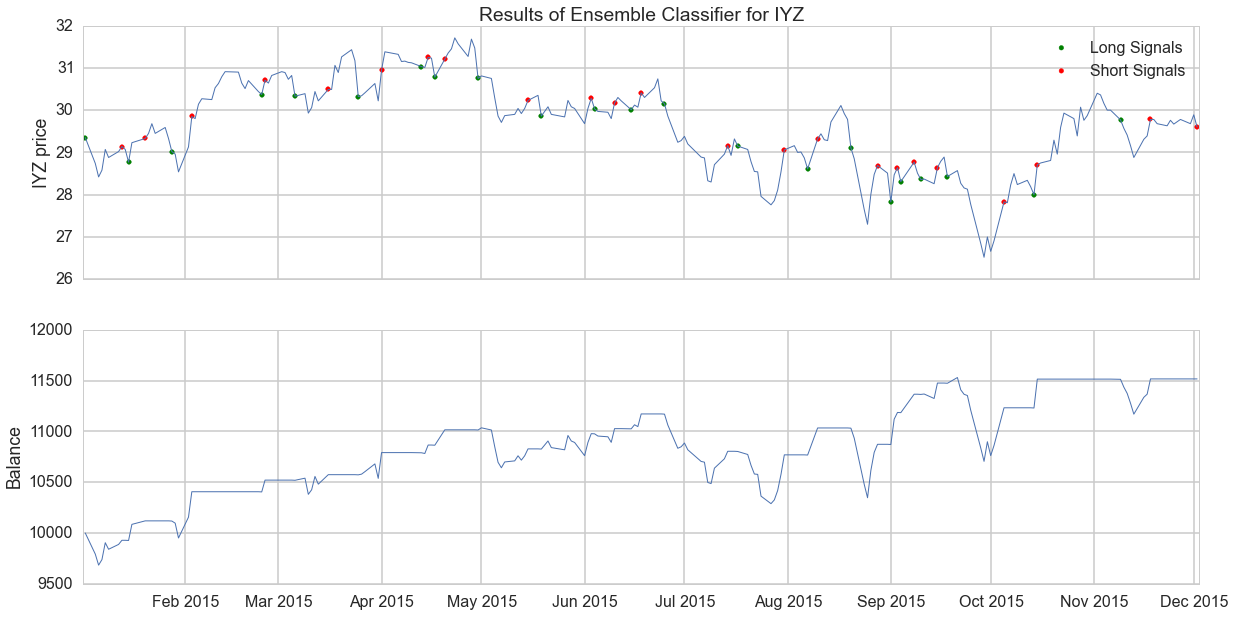

In [30]:
def plot_signal(model, title):
    fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharex=True)
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(model)[5][0])[0]
    short_prices=zip(*evaluate(model)[5][0])[1]
    long_days=zip(*evaluate(model)[5][1])[0]
    long_prices=zip(*evaluate(model)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    ax0.set_ylabel(ticker + " price")
    
    ax1.plot(zip(*evaluate(model)[6])[0], zip(*evaluate(model)[6])[1], lw=1)
    ax1.set_ylabel("Balance")
plot_signal(eclf, 'Results of Ensemble Classifier for '+ticker)

In [31]:
# Save results for this ticker to a JSON file
import json
fd = open("../ML_results/"+ticker+".json","w")
json.dump(Results, fd)
fd.close()

In [32]:
# Load results from all files
import glob
result_files = glob.glob("../ML_results/*.json")
print result_files
accuracies_all= {}
ROI_diff_all={}
ROI_all={}
for aFile in result_files:
    file_tickr = aFile[14:17]
    #print file_tickr
    with open(aFile, "r") as fd:
        result_dict = json.load(fd)
        models_acc = {}
        models_ROI_diff = {}
        models_ROI = {}
        for key, value in result_dict.iteritems():
            models_acc[key] =  value[1]
            models_ROI_diff[key] =  value[3]-value[2]
            models_ROI[key] =  value[3]
            accuracies_all[file_tickr] =  models_acc
            ROI_diff_all[file_tickr] =  models_ROI_diff
            ROI_all[file_tickr] =  models_ROI
accuracies_all=pd.DataFrame(accuracies_all)
ROI_diff_all=pd.DataFrame(ROI_diff_all)
ROI_all=pd.DataFrame(ROI_all)

['../ML_results/ITB.json', '../ML_results/IYE.json', '../ML_results/IYF.json', '../ML_results/IYH.json', '../ML_results/IYJ.json', '../ML_results/IYM.json', '../ML_results/IYR.json', '../ML_results/IYW.json', '../ML_results/IYZ.json']


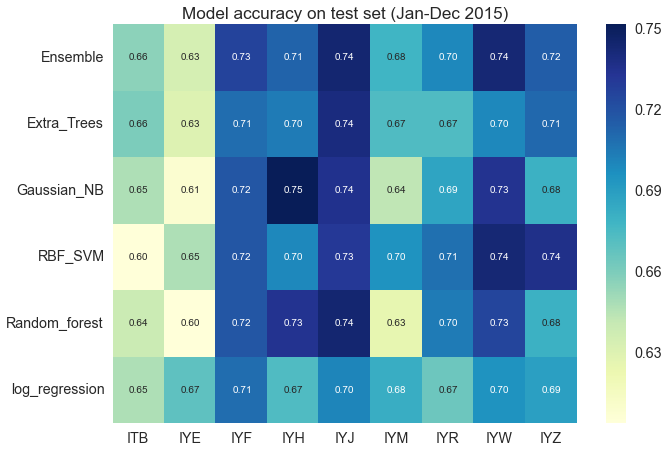

In [33]:
sns.set_context("talk", font_scale=1.1, rc={"lines.linewidth": 2.5})
ax = sns.heatmap(accuracies_all, annot=True, fmt='.2f',cmap="YlGnBu")
ax.set_title("Model accuracy on test set (Jan-Dec 2015)")

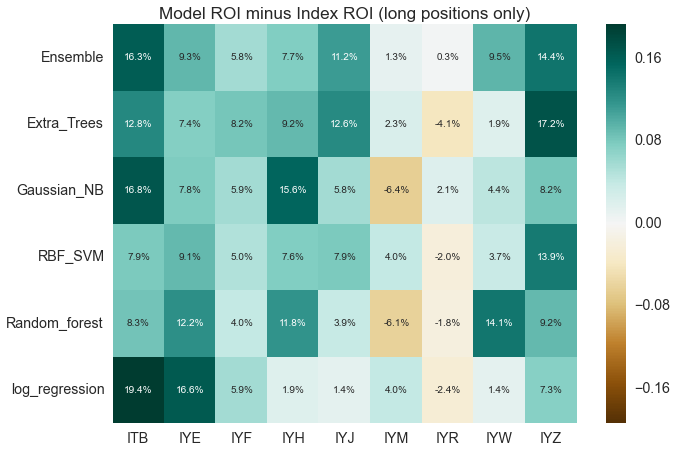

In [34]:
ax2 = sns.heatmap(ROI_diff_all, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI minus Index ROI (long positions only)")

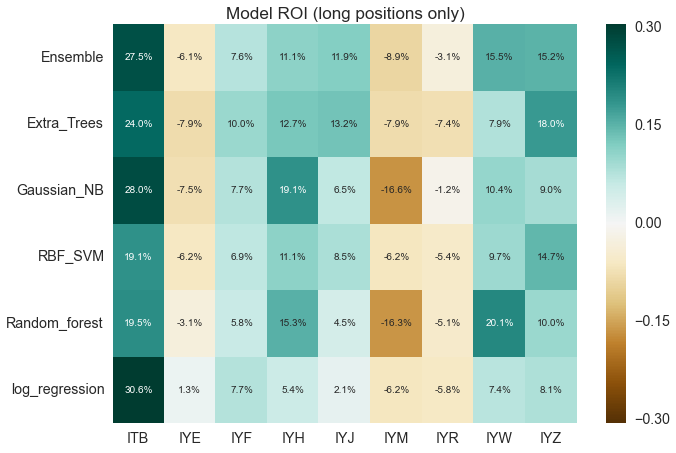

In [35]:
ax2 = sns.heatmap(ROI_all, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI (long positions only)")